In [5]:
import os, sys
import numpy as np
import torch
import matplotlib.pyplot as plt

In [6]:
d = os.getcwd()
p = os.path.dirname(d)

sys.path.append(p)

In [7]:
from src.dynamics import RobotWorld
from src.lqr import Lqr
from src.algorithms.adpgpd import ADpgpdExact
from src.sampling import Sampler

In [8]:
ds = 4
da = 2

eta = 0.01
tau = 0.1
gamma = 0.9
alpha = 1.0

b = -1

G1 = - torch.tensor([
    [10.0, 0, 0, 0],
    [0, 10.0, 0, 0],
    [0, 0, .1, 0],
    [0, 0, 0, .1]
]).double()

R1 =  - torch.tensor([
    [1., 0],
    [0, 1.],
]).double() * (tau / 2)

G2 = - torch.tensor([
    [.1, 0, 0, 0],
    [0, .1, 0, 0],
    [0, 0, 10.0, 0],
    [0, 0, 0, 10.0]
]).double()

R2 = - torch.tensor([
    [1., 0],
    [0, 1.],
]).double() * (tau / 2)

# Optimal

In [10]:
env = RobotWorld()
lqr = Lqr(env.A, env.B, gamma)
sampler = Sampler(env, gamma)

P = lqr.calculate_optimal_P(G1, R1)
K = lqr.calculate_optimal_K(R1, P)
opt_lqr = sampler.estimate_V_rho(P, 1_000_000)
opt_lqr

-3933.7574571198743

# Unconstrained

In [12]:
epochs = 1_000
n_pe = 1_000
n_rho = 1_000
eta = 0.01

env = RobotWorld()
sampler = Sampler(env, gamma)
dpgpd = ADpgpdExact(env, eta, tau, gamma, b, alpha, G1, G2, R1, R2)

K, losses_primal, losses_dual = dpgpd.train_unconstrained(epochs, n_pe, n_rho)

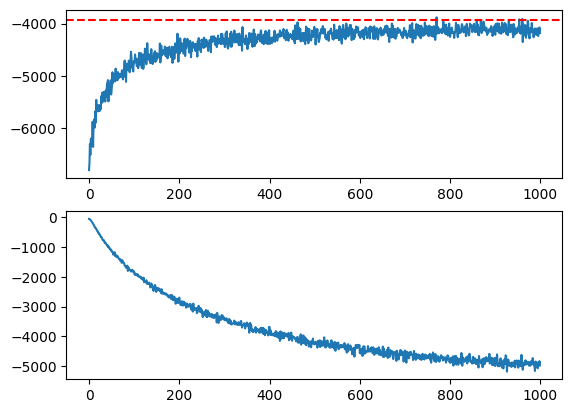

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
axes[0].axhline(y=opt_lqr, color='r', linestyle='--')
axes[1].plot(losses_dual)
plt.show()

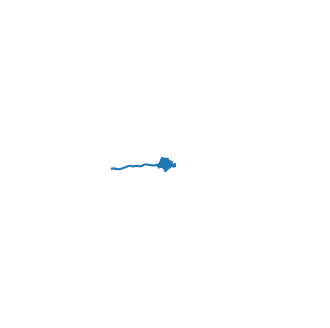

In [16]:
T = 1_000
states, actions = sampler.sample_trajectory(K, T)
plt.figure(figsize=[4, 4])
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.axis('off')
plt.show()

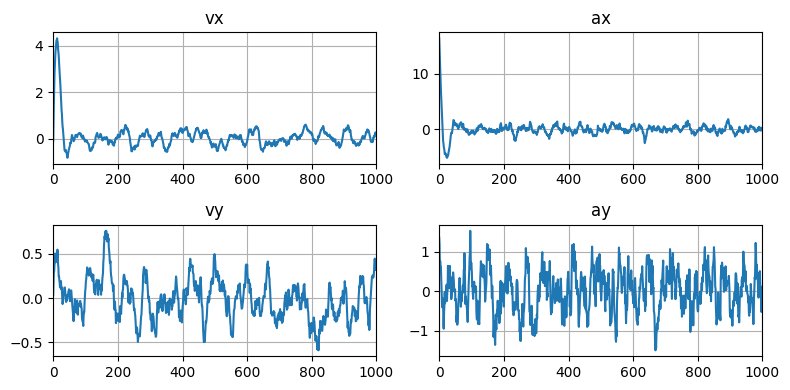

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[8, 4])

axes[0, 0].plot(states[:, 2])
axes[0, 0].grid()
axes[0, 0].set_title("vx")
axes[0, 0].set_xlim(0, T)

axes[1, 0].plot(states[:, 3])
axes[1, 0].grid()
axes[1, 0].set_title("vy")
axes[1, 0].set_xlim(0, T)

axes[0, 1].plot(actions[:, 0])
axes[0, 1].grid()
axes[0, 1].set_title("ax")
axes[0, 1].set_xlim(0, T)

axes[1, 1].plot(actions[:, 1])
axes[1, 1].grid()
axes[1, 1].set_title("ay")
axes[1, 1].set_xlim(0, T)

plt.tight_layout()
plt.show()

# Constrained

In [19]:
epochs = 1_000
n_pe = 1_000
n_rho = 1_000
b = - 2_000
eta = 0.01

env = RobotWorld()
sampler = Sampler(env, gamma)
dpgpd = ADpgpdExact(env, eta, tau, gamma, b, alpha, G1, G2, R1, R2)

K, lmbda, losses_primal, losses_dual = dpgpd.train_constrained(epochs, n_pe, n_rho)

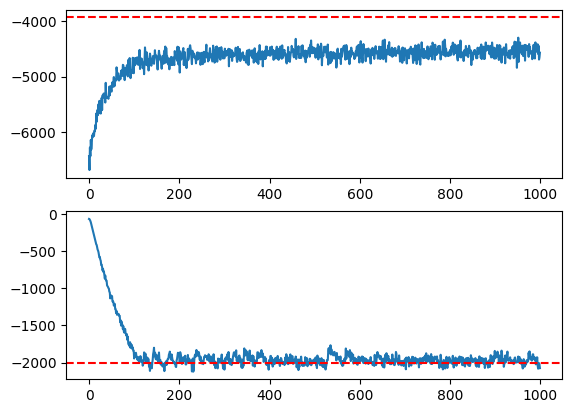

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
axes[0].axhline(y=opt_lqr, color='r', linestyle='--')
axes[1].plot(losses_dual)
axes[1].axhline(y=b, color='r', linestyle='--')
plt.show()

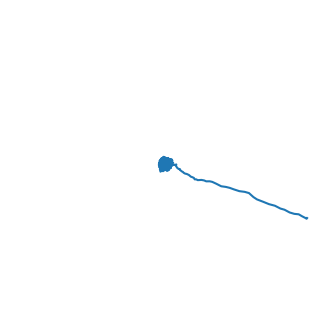

In [22]:
T = 1_000
states, actions = sampler.sample_trajectory(K, T)
plt.figure(figsize=[4, 4])
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.axis('off')
plt.show()

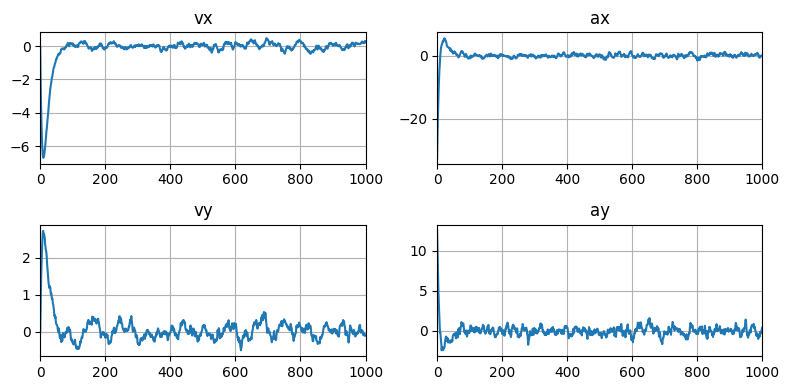

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[8, 4])

axes[0, 0].plot(states[:, 2])
axes[0, 0].grid()
axes[0, 0].set_title("vx")
axes[0, 0].set_xlim(0, T)

axes[1, 0].plot(states[:, 3])
axes[1, 0].grid()
axes[1, 0].set_title("vy")
axes[1, 0].set_xlim(0, T)

axes[0, 1].plot(actions[:, 0])
axes[0, 1].grid()
axes[0, 1].set_title("ax")
axes[0, 1].set_xlim(0, T)

axes[1, 1].plot(actions[:, 1])
axes[1, 1].grid()
axes[1, 1].set_title("ay")
axes[1, 1].set_xlim(0, T)

plt.tight_layout()
plt.show()

# Eta

In [25]:
tau = 0.1

pl_eta, dl_eta = [], []
etas = [0.1, 0.01, 0.001]
for eta in etas:
    epochs = 2_000
    n_pe = 1_000
    n_rho = 1_000
    b = -2_000

    env = RobotWorld()
    sampler = Sampler(env, gamma)
    dpgpd = ADpgpdExact(env, eta, tau, gamma, b, alpha, G1, G2, R1, R2)

    _, _, pl, dl = dpgpd.train_constrained(epochs, n_pe, n_rho)
    pl_eta.append(pl), dl_eta.append(dl)
pl_eta, dl_eta = np.array(pl_eta), np.array(dl_eta)

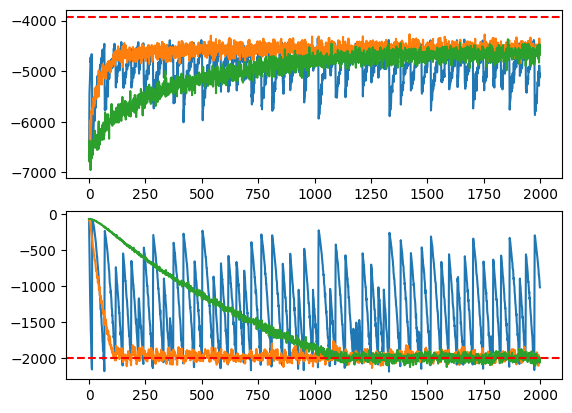

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=1)

axes = axes.flatten()
axes[0].plot(pl_eta[0])
axes[0].plot(pl_eta[1])
axes[0].plot(pl_eta[2])
axes[0].axhline(y=opt_lqr, color='r', linestyle='--')

axes[1].plot(dl_eta[0])
axes[1].plot(dl_eta[1])
axes[1].plot(dl_eta[2])
axes[1].axhline(y=b, color='r', linestyle='--')
plt.show()